In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql as psql 
import os

**PART 1: DATA PREPROCESSING**

* *Due to large dataset size of 18.55GB, we'll be reading data in chunk size to avoid memory allocation conflicts.*
* **Dask** is an open-source python library with the features of parallelism and scalability in Python included by default in Anaconda distribution.
*Dask gives much better response than using chunksize in pandas read_csv. 

In [2]:
# import dask
# from dask import dataframe as dd

# traindf = dd.read_csv('../input/ubiquant-market-prediction/train.csv')
# traindf.head()

What is **Parquet**?

*Parquet is an open source file format available to any project in the Hadoop ecosystem. Apache Parquet is designed for efficient as well as performant flat columnar storage format of data compared to row based files like CSV or TSV files.*

*Parquet uses the record shredding and assembly algorithm which is superior to simple flattening of nested namespaces. Parquet is optimized to work with complex data in bulk and features different ways for efficient data compression and encoding types. This approach is best especially for those queries that need to read certain columns from a large table. Parquet can only read the needed columns therefore greatly minimizing the IO.*

In [3]:
traindf = pd.read_parquet('../input/ubiquant-parquet/train.parquet')
traindf.head()

,row_id,time_id,investment_id,target,f_0,f_1,f_2,f_3,f_4,f_5,...,f_290,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299
0,0_1,0,1,-0.300875,0.932573,0.113691,-0.402206,0.378386,-0.203938,-0.413469,...,0.366028,-1.095620,0.200075,0.819155,0.941183,-0.086764,-1.087009,-1.044826,-0.287605,0.321566
1,0_2,0,2,-0.231040,0.810802,-0.514115,0.742368,-0.616673,-0.194255,1.771210,...,-0.154193,0.912726,-0.734579,0.819155,0.941183,-0.387617,-1.087009,-0.929529,-0.974060,-0.343624
2,0_6,0,6,0.568807,0.393974,0.615937,0.567806,-0.607963,0.068883,-1.083155,...,-0.138020,0.912726,-0.551904,-1.220772,-1.060166,-0.219097,-1.087009,-0.612428,-0.113944,0.243608
3,0_7,0,7,-1.064780,-2.343535,-0.011870,1.874606,-0.606346,-0.586827,-0.815737,...,0.382201,0.912726,-0.266359,-1.220772,0.941183,-0.609113,0.104928,-0.783423,1.151730,-0.773309
4,0_8,0,8,-0.531940,0.842057,-0.262993,2.330030,-0.583422,-0.618392,-0.742814,...,-0.170365,0.912726,-0.741355,-1.220772,0.941183,-0.588445,0.104928,0.753279,1.345611,-0.737624


In [4]:
traindf.dtypes

row_id            object
time_id            int64
investment_id      int64
target           float64
f_0              float64
                  ...   
f_295            float64
f_296            float64
f_297            float64
f_298            float64
f_299            float64
Length: 304, dtype: object

In [5]:
print("Total no. of datapoints present:",traindf.shape[0])

Total no. of datapoints present: 3141410


In [6]:
num_invests = traindf['investment_id'].nunique()
print(f"Total no. of investment: {num_invests} \
ranging from {traindf.investment_id.min()} to {traindf.investment_id.max()}")

Total no. of investment: 3579 ranging from 0 to 3773


The range of investments is more extended than the number fo assets themselves. In fact, assets will change in part in the test set, therefore we have to consider strategies for handling the ones in the training set in a generalizable way.

In [7]:
num_time_intervals = traindf['time_id'].nunique()
print(f"Each investment has maximum of {num_time_intervals} \
time intervals from a range of {traindf['time_id'].min()} to {traindf['time_id'].max()}")

Each investment has maximum of 1211 time intervals from a range of 0 to 1219


# **Target Analysis**

In [8]:
traindf[['investment_id','time_id','target']].head()

,investment_id,time_id,target
0,1,0,-0.300875
1,2,0,-0.231040
2,6,0,0.568807
3,7,0,-1.064780
4,8,0,-0.531940


In [9]:
traindf.groupby(['investment_id'])['target'].std()

investment_id
0       0.994126
1       0.889135
2       1.011378
3       1.032537
4       0.773464
          ...   
3768    0.705869
3769    0.870491
3770    1.095906
3772    0.878765
3773    1.458935
Name: target, Length: 3579, dtype: float64

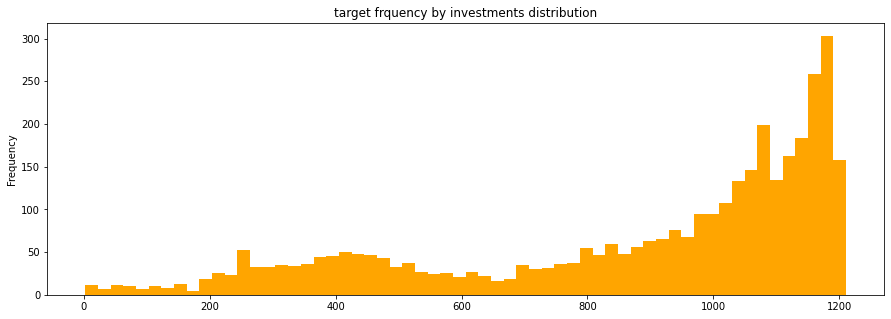

In [10]:
obs_by_invests = traindf.groupby(['investment_id'])['target'].count()

fig, ax = plt.subplots(1, 1, figsize = (15,5))
obs_by_invests.plot.hist(bins = 60, color = 'orange')
plt.title('target frquency by investments distribution')
plt.show()

More target values lies between the end part of region, basically the investments between ids 1000-1200. Assets are distributed in a different way, there are assets that are actually more frequently observed and others that are not. 

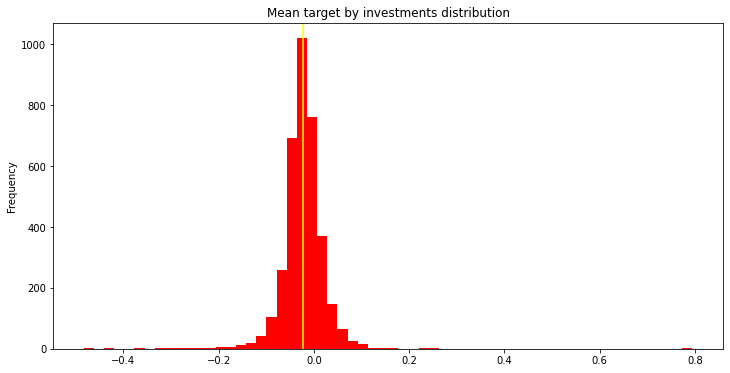

Mean value of target:-0.02310


In [11]:
mean_target_by_invests = traindf.groupby(['investment_id'])['target'].mean()
mean_target = np.mean(mean_target_by_invests)

fig, ax = plt.subplots(1, 1, figsize = (12,6))
mean_target_by_invests.plot.hist(bins = 60, color = 'red')  
plt.axvline(x = mean_target, color = 'yellow')
plt.title('Mean target by investments distribution')
plt.show()

print(f"Mean value of target:{mean_target: 0.5f}") 

The distribution seems to be a bell shaped curve graph, therefore towards a normal distribution. But there are few outliers as well, especially in the -0.4 (negative target ones) and +0.8 (positive target ones) side.
Overall the average mean target is slightly towards negative side. 

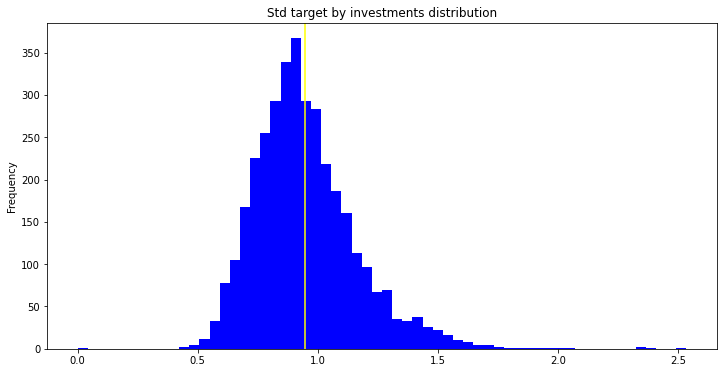

Std value of target: 0.94790


In [12]:
std_target_by_invests = traindf.groupby(['investment_id'])['target'].std()
mean_std_target = np.mean(std_target_by_invests)

fig, ax = plt.subplots(1, 1, figsize = (12,6))
std_target_by_invests.plot.hist(bins = 60, color = 'blue')  
plt.axvline(x = mean_std_target, color = 'yellow')
plt.title('Std target by investments distribution')
plt.show()
print(f"Std value of target:{mean_std_target: 0.5f}") 

Text(0.5, 1.0, 'Distribution of time v/s investements')

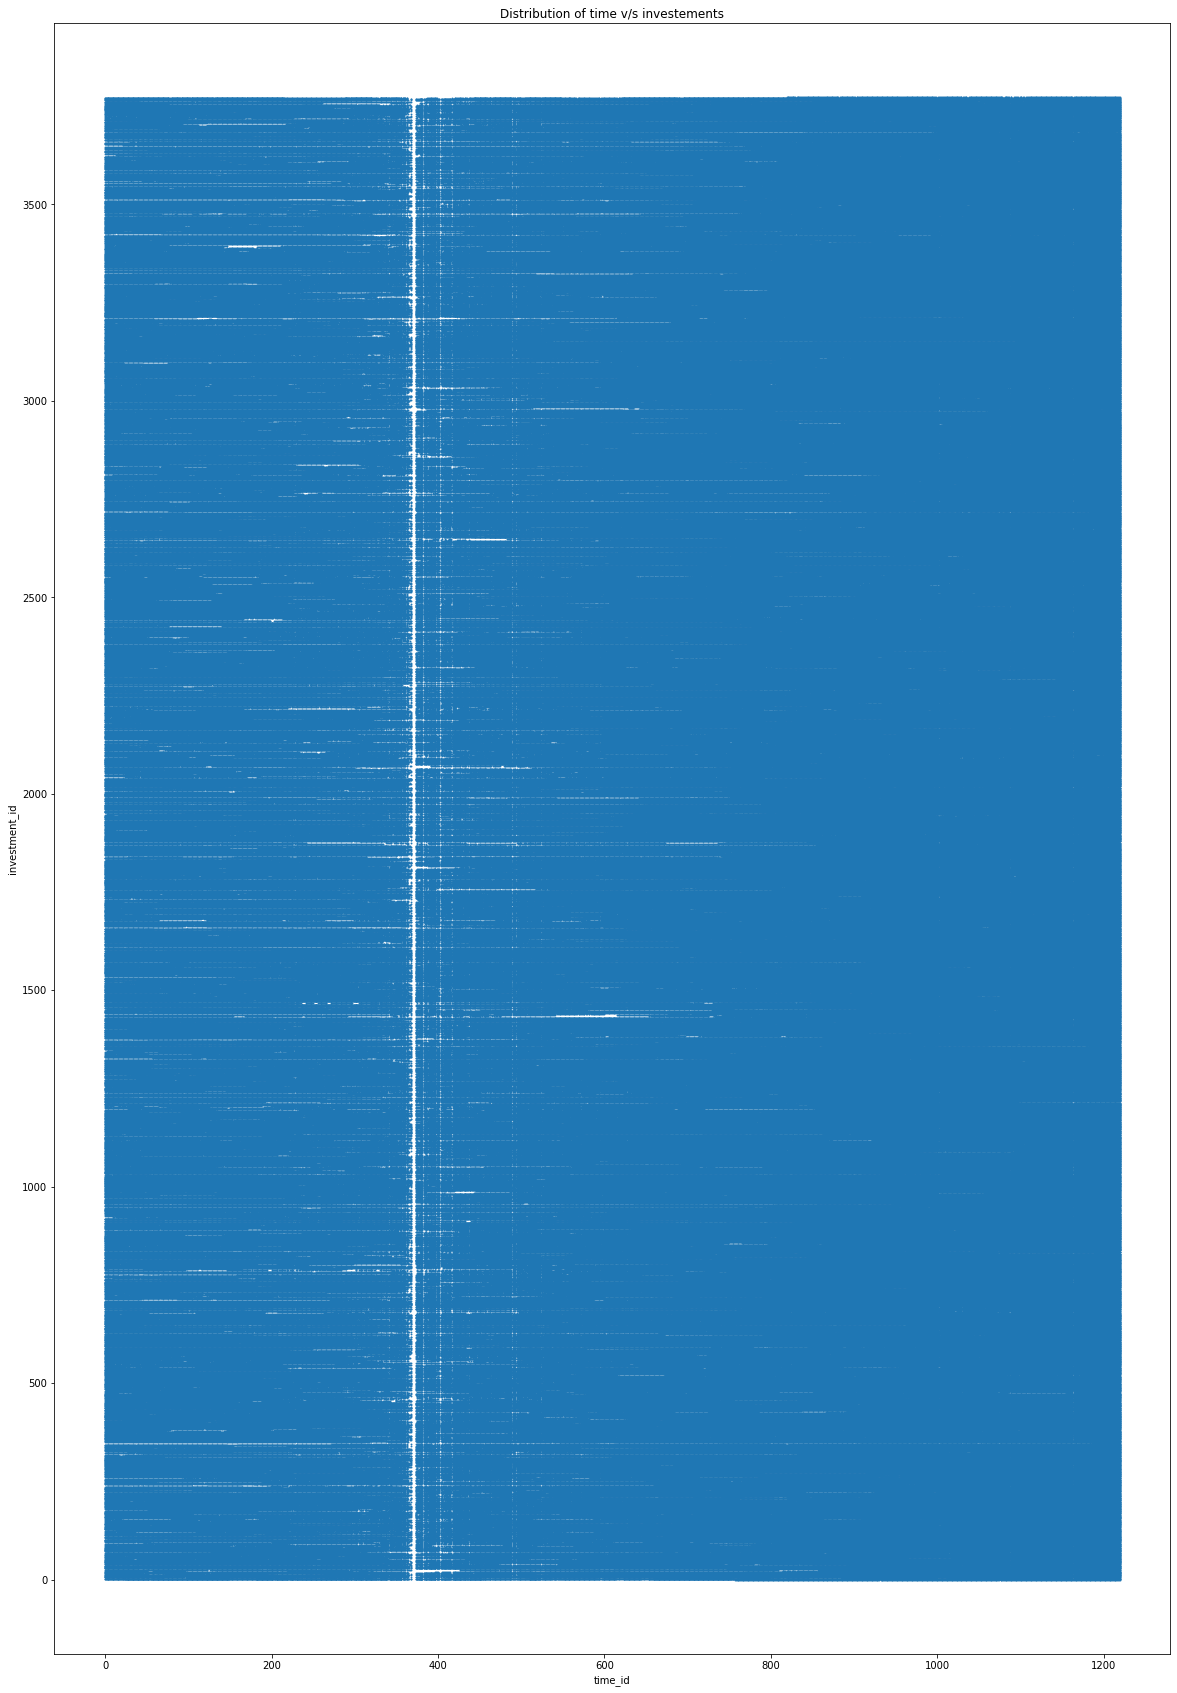

In [13]:
traindf[['time_id', 'investment_id']].plot.scatter('time_id', 'investment_id', figsize=(20,30), s= 0.8)
plt.title('Distribution of time v/s investements')

As observed with fabrics of investments over time, more discontinuities are present in the 1st section of the time. 

In [14]:
sns.jointplot

<function seaborn.axisgrid.jointplot(*, x=None, y=None, data=None, kind='scatter', color=None, height=6, ratio=5, space=0.2, dropna=False, xlim=None, ylim=None, marginal_ticks=False, joint_kws=None, marginal_kws=None, hue=None, palette=None, hue_order=None, hue_norm=None, **kwargs)>